# TF-IDF + SVM

## Data Load and Preprocess

In [ ]:
!pip install pandas numpy scikit-learn

In [ ]:
import os
import json
import re
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = "/content/drive/MyDrive/HateXplain-master/Data"

dataset_path = os.path.join(DATA_DIR, "dataset.json")
splits_path  = os.path.join(DATA_DIR, "post_id_divisions.json")
classes_path = os.path.join(DATA_DIR, "classes.npy")

with open(dataset_path, "r") as f:
    raw_data = json.load(f)

with open(splits_path, "r") as f:
    splits = json.load(f)
#used chat gpt to get allow pickle
class_names = np.load(classes_path, allow_pickle=True)

print("Num posts:", len(raw_data))
print("Split sizes:", {k: len(v) for k, v in splits.items()})
print("3-class labels:", class_names)

In [8]:

#Used claude here to get an idea of how to setup the label structure
def get_majority_label(annotators):
    labels = [a["label"] for a in annotators if "label" in a]
    if not labels:
        return None
    return Counter(labels).most_common(1)[0][0]

def get_majority_target(annotators):
    all_targets = []
    for a in annotators:
        t = a.get("target", [])
        if isinstance(t, list):
            all_targets.extend(t)
    if not all_targets:
        return "None"
    return Counter(all_targets).most_common(1)[0][0]

# used claude for map post id and chunk of code here
id_to_split = {}
for split_name, id_list in splits.items():
    for pid in id_list:
        id_to_split[pid] = split_name

rows = []
idx_map = {name: i for i, name in enumerate(class_names)}

for post_id, entry in raw_data.items():
    tokens = entry.get("post_tokens", [])
    text = " ".join(tokens)

    annotators = entry.get("annotators", [])
    label = get_majority_label(annotators)
    target = get_majority_target(annotators)

    if label is None:
        continue

    # 3 classes to classify with
    label_3class_str = label
    label_3class_id = idx_map[label_3class_str]

    split_name = id_to_split.get(post_id, "unknown")

    rows.append({
        "post_id": post_id,
        "text": text,
        "label_3class_str": label_3class_str,
        "label_3class_id": label_3class_id,
        "target_group": target,
        "split": split_name
    })

df = pd.DataFrame(rows)
df.head(15)

,post_id,text,label_3class_str,label_3class_id,target_group,split
0,1179055004553900032_twitter,i dont think im getting my baby them white 9 h...,normal,1,None,test
1,1179063826874032128_twitter,we cannot continue calling ourselves feminists...,normal,1,None,train
2,1178793830532956161_twitter,nawt yall niggers ignoring me,normal,1,African,train
3,1179088797964763136_twitter,<user> i am bit confused coz chinese ppl can n...,hatespeech,0,Asian,train
4,1179085312976445440_twitter,this bitch in whataburger eating a burger with...,hatespeech,0,Caucasian,val
5,13851720_gab,laura loomer raped me while screaming at me in...,hatespeech,0,Jewish,test
6,24198545_gab,and this is why i end up with nigger trainee d...,hatespeech,0,African,train
7,14567516_gab,nogs jews and dykes how enriching,offensive,2,Jewish,train
8,19679648_gab,guilty until proven innocent unless you are a ...,hatespeech,0,African,train
9,15858421_gab,tired i can not support abortion from a moral ...,hatespeech,0,African,val


In [ ]:
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

print(train_df["label_3class_str"].value_counts())
print(train_df["target_group"].value_counts().head(15))

Train: (15383, 7) Val: (1922, 7) Test: (1924, 7)
label_3class_str
normal        6251
hatespeech    4748
offensive     4384
Name: count, dtype: int64
target_group
None          5384
African       2371
Islam         1456
Homosexual    1270
Jewish        1233
Women          951
Other          637
Refugee        603
Arab           447
Caucasian      348
Asian          268
Hispanic       204
Men             94
Disability      38
Christian       29
Name: count, dtype: int64


## Task 1: Hate Vs Non-Hate Classification

In [ ]:
#random seed
np.random.seed(42)

In [ ]:
# TF-IDF parameters - got parameter uggestions from chat gpt
tfidf_3class = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=True
)

# Fit on training data
X_train_3class = tfidf_3class.fit_transform(train_df["text"].astype(str))
X_val_3class = tfidf_3class.transform(val_df["text"].astype(str))
y_3class_train = train_df["label_3class_id"].values
y_3class_val = val_df["label_3class_id"].values

print("\nClass distr:")
print(train_df["label_3class_str"].value_counts())

TF-IDF shape - Train: (15383, 10000), Val: (1922, 10000)
Vocabulary size: 10000

Class distribution in training set:
label_3class_str
normal        6251
hatespeech    4748
offensive     4384
Name: count, dtype: int64


In [ ]:
# Using LinearSVC because rbf kernel was too slow - got grid parametersfrom chat gpt
param_grid = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced', None]
}

svm_3class_base = LinearSVC(random_state=42, max_iter=2000, dual=False)

# Grid search with 3-fold CV - got syntac on how to use GridSearchCv from claude
grid_search_3class = GridSearchCV(
    svm_3class_base,
    param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

print("\nrunning...")
grid_search_3class.fit(X_train_3class, y_3class_train)

print(f"\nBest params: {grid_search_3class.best_params_}")
print(f"Best score (macro F1): {grid_search_3class.best_score_:.4f}")

svm_3class = grid_search_3class.best_estimator_


Training SVM for 3-class classification...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'C': 0.1, 'class_weight': 'balanced'}
Best cross-validation score (macro F1): 0.5808


In [ ]:
# predictions
y_val_pred_3class = svm_3class.predict(X_val_3class)

# report formatting - code from claude
class_names_ordered = ['hatespeech', 'normal', 'offensive']

print("\n=== Task 1: Three-Class Classification (TF-IDF + SVM) ===")
print(classification_report(y_3class_val, y_val_pred_3class,
                          target_names=class_names_ordered,
                          digits=4))

print("\nConfusion matrix:")
print("Rows: True labels, Columns: Predicted labels")
print("Order: [hatespeech, normal, offensive]")
cm = confusion_matrix(y_3class_val, y_val_pred_3class)
print(cm)

# Calculate metrics
macro_f1_3class = f1_score(y_3class_val, y_val_pred_3class, average="macro")
weighted_f1_3class = f1_score(y_3class_val, y_val_pred_3class, average="weighted")
accuracy_3class = (y_val_pred_3class == y_3class_val).mean()

print(f"\nAccuracy: {accuracy_3class:.4f}")
print(f"Macro F1: {macro_f1_3class:.4f}")
print(f"Weighted F1: {weighted_f1_3class:.4f}")


=== Task 1: Three-Class Classification (TF-IDF + SVM) ===
              precision    recall  f1-score   support

  hatespeech     0.7240    0.7032    0.7134       593
      normal     0.6507    0.7324    0.6892       781
   offensive     0.5375    0.4580    0.4946       548

    accuracy                         0.6452      1922
   macro avg     0.6374    0.6312    0.6324      1922
weighted avg     0.6410    0.6452    0.6412      1922


Confusion matrix:
Rows: True labels, Columns: Predicted labels
Order: [hatespeech, normal, offensive]
[[417 108  68]
 [ 61 572 148]
 [ 98 199 251]]

Accuracy: 0.6452
Macro F1: 0.6324
Weighted F1: 0.6412


## Task 2: Target Group Multi-Class Classification

In [ ]:
#getting counts for target groups
MIN_SAMPLES = 200 #threshold for counting
#chunk of code suggested by claude
target_counts = train_df["target_group"].value_counts()
valid_groups = target_counts[target_counts >= MIN_SAMPLES].index.tolist()
print("Selected groups:", valid_groups)

train_group_df = train_df[train_df["target_group"].isin(valid_groups)].reset_index(drop=True)
val_group_df   = val_df[val_df["target_group"].isin(valid_groups)].reset_index(drop=True)

print("Train groups:", train_group_df.shape, "Val groups:", val_group_df.shape)
print(train_group_df["target_group"].value_counts())

Selected groups: ['None', 'African', 'Islam', 'Homosexual', 'Jewish', 'Women', 'Other', 'Refugee', 'Arab', 'Caucasian', 'Asian', 'Hispanic']
Train groups: (15172, 7) Val groups: (1896, 7)
target_group
None          5384
African       2371
Islam         1456
Homosexual    1270
Jewish        1233
Women          951
Other          637
Refugee        603
Arab           447
Caucasian      348
Asian          268
Hispanic       204
Name: count, dtype: int64


In [ ]:
# TF-IDF vectorizer and used the same params as task1
tfidf_group = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=True
)

X_train_group = tfidf_group.fit_transform(train_group_df["text"].astype(str))
X_val_group = tfidf_group.transform(val_group_df["text"].astype(str))

# Encode target groups
le_group = LabelEncoder()
y_group_train = le_group.fit_transform(train_group_df["target_group"])
y_group_val = le_group.transform(val_group_df["target_group"])



Groups: ['African', 'Arab', 'Asian', 'Caucasian', 'Hispanic', 'Homosexual', 'Islam', 'Jewish', 'None', 'Other', 'Refugee', 'Women']
Number of groups: 12
TF-IDF shape - Train: (15172, 10000), Val: (1896, 10000)


In [ ]:
# Multi-class SVM and same params as before
param_grid_group = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced', None]
}

svm_group_base = LinearSVC(
    random_state=42,
    max_iter=2000,
    dual=False,
    multi_class='ovr'  #ovr suggested by claude
)

grid_search_group = GridSearchCV(
    svm_group_base,
    param_grid_group,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_search_group.fit(X_train_group, y_group_train)

print(f"\nBest params: {grid_search_group.best_params_}")
print(f"Best score (macro F1): {grid_search_group.best_score_:.4f}")

svm_group = grid_search_group.best_estimator_

Training SVM for target group classification...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'C': 0.1, 'class_weight': 'balanced'}
Best cross-validation score (macro F1): 0.5812


In [ ]:
y_group_val_pred = svm_group.predict(X_val_group)
#print report format from claude
print("=== Task 2: Target Group (TF-IDF + SVM) ===")
print(classification_report(
    y_group_val,
    y_group_val_pred,
    target_names=le_group.classes_,
    digits=4
))

macro_f1_group = f1_score(y_group_val, y_group_val_pred, average="macro")
print(f"\nMacro F1 (groups): {macro_f1_group:.4f}")

=== Task 2: Target Group (TF-IDF + SVM) ===
              precision    recall  f1-score   support

     African     0.7658    0.7031    0.7331       293
        Arab     0.6528    0.8246    0.7287        57
       Asian     0.5000    0.8889    0.6400        27
   Caucasian     0.2289    0.4524    0.3040        42
    Hispanic     0.7619    0.8421    0.8000        19
  Homosexual     0.6574    0.8765    0.7513       162
       Islam     0.7157    0.7978    0.7545       183
      Jewish     0.8049    0.8571    0.8302       154
        None     0.7462    0.4230    0.5399       695
       Other     0.2832    0.3678    0.3200        87
     Refugee     0.5278    0.8382    0.6477        68
       Women     0.4020    0.7523    0.5240       109

    accuracy                         0.6313      1896
   macro avg     0.5872    0.7187    0.6311      1896
weighted avg     0.6770    0.6313    0.6295      1896


Macro F1 (groups): 0.6311


# GloVe

In [ ]:
import os
import json
import re
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

In [ ]:
DATA_DIR = "/content/drive/MyDrive/HateXplain-master/Data" # similar code setup as tf-idf kept both versions in case wanted to remove an approach

dataset_path = os.path.join(DATA_DIR, "dataset.json")
splits_path  = os.path.join(DATA_DIR, "post_id_divisions.json")
classes_path = os.path.join(DATA_DIR, "classes.npy")

with open(dataset_path, "r") as f:
    raw_data = json.load(f)

with open(splits_path, "r") as f:
    splits = json.load(f)

class_names = np.load(classes_path, allow_pickle=True)

print("Num posts:", len(raw_data))
print("Split sizes:", {k: len(v) for k, v in splits.items()})
print("3-class labels:", class_names)

Num posts: 20148
Split sizes: {'test': 1924, 'train': 15383, 'val': 1922}
3-class labels: ['hatespeech' 'normal' 'offensive']


In [ ]:
def get_majority_label(annotators):
    labels = [a["label"] for a in annotators if "label" in a]
    if not labels:
        return None
    return Counter(labels).most_common(1)[0][0]

def get_majority_target(annotators):
    all_targets = []
    for a in annotators:
        t = a.get("target", [])
        if isinstance(t, list):
            all_targets.extend(t)
    if not all_targets:
        return "None"
    return Counter(all_targets).most_common(1)[0][0]

#copied from tf-idf
id_to_split = {}
for split_name, id_list in splits.items():
    for pid in id_list:
        id_to_split[pid] = split_name

rows = []
idx_map = {name: i for i, name in enumerate(class_names)}

for post_id, entry in raw_data.items():
    tokens = entry.get("post_tokens", [])
    text = " ".join(tokens)

    annotators = entry.get("annotators", [])
    label = get_majority_label(annotators)
    target = get_majority_target(annotators)

    if label is None:
        continue

    # 3-class label
    label_3class_str = label

    label_3class_id = idx_map[label_3class_str]


    split_name = id_to_split.get(post_id, "unknown")

    rows.append({
        "post_id": post_id,
        "text": text,
        "label_3class_str": label_3class_str,
        "label_3class_id": label_3class_id,
        "target_group": target,
        "split": split_name
    })

df = pd.DataFrame(rows)
df.head() #to see what some of the data looks like

,post_id,text,label_3class_str,label_3class_id,label_binary,target_group,split
0,1179055004553900032_twitter,i dont think im getting my baby them white 9 h...,normal,1,0,None,test
1,1179063826874032128_twitter,we cannot continue calling ourselves feminists...,normal,1,0,None,train
2,1178793830532956161_twitter,nawt yall niggers ignoring me,normal,1,0,African,train
3,1179088797964763136_twitter,<user> i am bit confused coz chinese ppl can n...,hatespeech,0,1,Asian,train
4,1179085312976445440_twitter,this bitch in whataburger eating a burger with...,hatespeech,0,1,Caucasian,val


In [ ]:
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

print(train_df["label_3class_str"].value_counts())
print(train_df["target_group"].value_counts().head(15))

Train: (15383, 7) Val: (1922, 7) Test: (1924, 7)
label_3class_str
normal        6251
hatespeech    4748
offensive     4384
Name: count, dtype: int64
target_group
None          5384
African       2371
Islam         1456
Homosexual    1270
Jewish        1233
Women          951
Other          637
Refugee        603
Arab           447
Caucasian      348
Asian          268
Hispanic       204
Men             94
Disability      38
Christian       29
Name: count, dtype: int64


## Glove Embeddings

In [ ]:
import os
import zipfile
import urllib.request

#loading glove and used claude to do this for syntax and ordering purposes
os.makedirs(DATA_DIR, exist_ok=True)

GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = os.path.join(DATA_DIR, "glove.6B.zip")
GLOVE_PATH = os.path.join(DATA_DIR, "glove.6B.100d.txt")

# Download if not already there
if not os.path.exists(GLOVE_PATH):
    print("Downloading GloVe embeddings (862 MB)... This may take a few minutes.")
    urllib.request.urlretrieve(GLOVE_URL, GLOVE_ZIP)

    print("Extracting...")
    with zipfile.ZipFile(GLOVE_ZIP, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

    os.remove(GLOVE_ZIP)
    print(f"GloVe embeddings saved to {DATA_DIR}")
else:
    print("GloVe embeddings already exist!")

GloVe embeddings already exist!


In [ ]:
#used claude for this code as well to load glove embeddings
EMBEDDING_DIM = 100
GLOVE_PATH = os.path.join(DATA_DIR, "glove.6B.100d.txt")

print("Loading GloVe embeddings...")
embeddings_index = {}
with open(GLOVE_PATH, encoding="utf8") as f:
    for line in f:
        values = line.rstrip().split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")

Loading GloVe embeddings...
Loaded 400000 word vectors.


## Text to vector conversion

In [ ]:
#vector conversion - used claude here as well for logic and structure
def text_to_vector(text, embeddings_dict, embedding_dim=100, aggregation='mean'):
    words = text.lower().split()
    word_vectors = []

    for word in words:
        if word in embeddings_dict:
            word_vectors.append(embeddings_dict[word])

    if not word_vectors:
        # Return zero vector if no words found
        if aggregation == 'combined':
            return np.zeros(embedding_dim * 3)
        else:
            return np.zeros(embedding_dim)

    word_vectors = np.array(word_vectors)

    if aggregation == 'mean':
        return np.mean(word_vectors, axis=0)
    elif aggregation == 'max':
        return np.max(word_vectors, axis=0)
    elif aggregation == 'min':
        return np.min(word_vectors, axis=0)
    elif aggregation == 'combined':
        mean_vec = np.mean(word_vectors, axis=0)
        max_vec = np.max(word_vectors, axis=0)
        min_vec = np.min(word_vectors, axis=0)
        return np.concatenate([mean_vec, max_vec, min_vec])
    else:
        raise ValueError(f"Unknown aggregation: {aggregation}")

def texts_to_matrix(texts, embeddings_dict, embedding_dim=100, aggregation='mean'):
    vectors = []
    for text in texts:
        vec = text_to_vector(text, embeddings_dict, embedding_dim, aggregation)
        vectors.append(vec)
    return np.array(vectors)

# Test the function
sample_text = train_df.iloc[0]['text']
sample_vec = text_to_vector(sample_text, embeddings_index, EMBEDDING_DIM, 'mean')
print(f"Sample text: {sample_text[:100]}...")
print(f"Vector shape: {sample_vec.shape}")
print(f"First 10 values: {sample_vec[:10]}")

Sample text: we cannot continue calling ourselves feminists if the rights of all womxn arent addressed yes to a s...
Vector shape: (100,)
First 10 values: [-0.047285    0.12937686  0.19200067 -0.19875029  0.05225701  0.29438102
 -0.28517863  0.07414474 -0.02866697  0.02625715]


## Task 1

In [ ]:
# Set random
np.random.seed(42)

In [ ]:
#use of aggregation from chat gpt
AGGREGATION = 'combined'
print(f"Converting texts to vectors using '{AGGREGATION}' aggregation...")
X_train_3class = texts_to_matrix(
    train_df["text"].astype(str),
    embeddings_index,
    EMBEDDING_DIM,
    AGGREGATION
)
X_val_3class = texts_to_matrix(
    val_df["text"].astype(str),
    embeddings_index,
    EMBEDDING_DIM,
    AGGREGATION
)

y_3class_train = train_df["label_3class_id"].values
y_3class_val = val_df["label_3class_id"].values

# Print class distribution
print("\nClass distribution in training set:")
print(train_df["label_3class_str"].value_counts())

Converting texts to vectors using 'combined' aggregation...
Feature matrix shape - Train: (15383, 300), Val: (1922, 300)

Class distribution in training set:
label_3class_str
normal        6251
hatespeech    4748
offensive     4384
Name: count, dtype: int64


In [ ]:
from sklearn.svm import LinearSVC
#linear svc run simila to tf-idf tasks
param_grid_svm = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced', None]
}

svm_3class_base = LinearSVC(random_state=42, max_iter=2000)

grid_search_svm = GridSearchCV(
    svm_3class_base,
    param_grid_svm,
    cv=3,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

print("\nRunning...")
grid_search_svm.fit(X_train_3class, y_3class_train)

print(f"\nBest params: {grid_search_svm.best_params_}")
print(f"Best score (macro F1): {grid_search_svm.best_score_:.4f}")

svm_3class = grid_search_svm.best_estimator_


Training SVM for 3-class classification with GloVe embeddings...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'C': 0.1, 'class_weight': 'balanced'}
Best cross-validation score (macro F1): 0.5093


In [ ]:
# Random Forest - done for variety and comparision in classifcation
#grid parameters and random forest structure from claude
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}

rf_3class_base = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    rf_3class_base,
    param_grid_rf,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

print("\nrunning....")
grid_search_rf.fit(X_train_3class, y_3class_train)

print(f"\nBest params: {grid_search_rf.best_params_}")
print(f"Best score (macro F1): {grid_search_rf.best_score_:.4f}")

rf_3class = grid_search_rf.best_estimator_



Training Random Forest for 3-class classification with GloVe embeddings...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score (macro F1): 0.5062


In [ ]:
# Comparing  Models
# SVM
y_val_pred_svm = svm_3class.predict(X_val_3class)
f1_svm = f1_score(y_3class_val, y_val_pred_svm, average='macro')

# Random Forest
y_val_pred_rf = rf_3class.predict(X_val_3class)
f1_rf = f1_score(y_3class_val, y_val_pred_rf, average='macro')

print(f"\nSVM Macro F1: {f1_svm:.4f}")
print(f"Random Forest Macro F1: {f1_rf:.4f}")


SVM Macro F1: 0.5587
Random Forest Macro F1: 0.5710

Best model for Task 1: Random Forest


In [ ]:
#report format- from claude
class_names_ordered = ['hatespeech', 'normal', 'offensive']

print(f"\n=== Task 1: Three-Class Classification (GloVe + {best_name_3class}) ===")
print(classification_report(y_3class_val, y_val_pred_3class,
                          target_names=class_names_ordered,
                          digits=4))

print("\nConfusion matrix:")
print("Rows: True labels, Columns: Predicted labels")
print("Order: [hatespeech, normal, offensive]")
cm = confusion_matrix(y_3class_val, y_val_pred_3class)
print(cm)

# Calculate additional metrics
weighted_f1_3class = f1_score(y_3class_val, y_val_pred_3class, average="weighted")
accuracy_3class = (y_val_pred_3class == y_3class_val).mean()

print(f"\nAccuracy: {accuracy_3class:.4f}")
print(f"Macro F1: {macro_f1_3class:.4f}")
print(f"Weighted F1: {weighted_f1_3class:.4f}")


=== Task 1: Three-Class Classification (GloVe + Random Forest) ===
              precision    recall  f1-score   support

  hatespeech     0.7536    0.5261    0.6197       593
      normal     0.5574    0.7644    0.6447       781
   offensive     0.5057    0.4033    0.4487       548

    accuracy                         0.5879      1922
   macro avg     0.6056    0.5646    0.5710      1922
weighted avg     0.6032    0.5879    0.5811      1922


Confusion matrix:
Rows: True labels, Columns: Predicted labels
Order: [hatespeech, normal, offensive]
[[312 202  79]
 [ 47 597 137]
 [ 55 272 221]]

Accuracy: 0.5879
Macro F1: 0.5710
Weighted F1: 0.5811


## Task 2

In [ ]:
#same setup counting as tf-idf task 2
MIN_SAMPLES = 200

target_counts = train_df["target_group"].value_counts()
valid_groups = target_counts[target_counts >= MIN_SAMPLES].index.tolist()
print("Selected groups:", valid_groups)

train_group_df = train_df[train_df["target_group"].isin(valid_groups)].reset_index(drop=True)
val_group_df   = val_df[val_df["target_group"].isin(valid_groups)].reset_index(drop=True)

print("Train groups:", train_group_df.shape, "Val groups:", val_group_df.shape)
print(train_group_df["target_group"].value_counts())

Selected groups: ['None', 'African', 'Islam', 'Homosexual', 'Jewish', 'Women', 'Other', 'Refugee', 'Arab', 'Caucasian', 'Asian', 'Hispanic']
Train groups: (15172, 7) Val groups: (1896, 7)
target_group
None          5384
African       2371
Islam         1456
Homosexual    1270
Jewish        1233
Women          951
Other          637
Refugee        603
Arab           447
Caucasian      348
Asian          268
Hispanic       204
Name: count, dtype: int64


In [ ]:
#converting texts
X_train_group = texts_to_matrix(
    train_group_df["text"].astype(str),
    embeddings_index,
    EMBEDDING_DIM,
    AGGREGATION
)
X_val_group = texts_to_matrix(
    val_group_df["text"].astype(str),
    embeddings_index,
    EMBEDDING_DIM,
    AGGREGATION
)

# Encode target groups
le_group = LabelEncoder()
y_group_train = le_group.fit_transform(train_group_df["target_group"])
y_group_val = le_group.transform(val_group_df["target_group"])


print(f"\nGroups: {list(le_group.classes_)}")

print(f"Feature matrix shape - Train: {X_train_group.shape}, Val: {X_val_group.shape}")

Converting target group texts to vectors using 'combined' aggregation...

Groups: ['African', 'Arab', 'Asian', 'Caucasian', 'Hispanic', 'Homosexual', 'Islam', 'Jewish', 'None', 'Other', 'Refugee', 'Women']
Number of groups: 12
Feature matrix shape - Train: (15172, 300), Val: (1896, 300)


In [ ]:
# Same for target groups
param_grid_svm_group = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced', None]
}

svm_group_base = LinearSVC(random_state=42, max_iter=2000)

grid_search_svm_group = GridSearchCV(
    svm_group_base,
    param_grid_svm_group,
    cv=3,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

print("running")
grid_search_svm_group.fit(X_train_group, y_group_train)

print(f"\nBest parames: {grid_search_svm_group.best_params_}")
print(f"Bestscore (macro F1): {grid_search_svm_group.best_score_:.4f}")

svm_group = grid_search_svm_group.best_estimator_

Training SVM for target group classification...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'C': 0.1, 'class_weight': 'balanced'}
Best cross-validation score (macro F1): 0.4177


In [ ]:
# Multi-class Random Forest
param_grid_rf_group = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}
#used claude like in task 1 for params
rf_group_base = RandomForestClassifier(random_state=42)
grid_search_rf_group = GridSearchCV(
    rf_group_base,
    param_grid_rf_group,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)
print("running")
grid_search_rf_group.fit(X_train_group, y_group_train)

print(f"\nBest params: {grid_search_rf_group.best_params_}")
print(f"Best score (macro F1): {grid_search_rf_group.best_score_:.4f}")

rf_group = grid_search_rf_group.best_estimator_

Training Random Forest for target group classification...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score (macro F1): 0.4650


In [ ]:
#comparing like in task 1
# SVM predictions
y_group_val_pred_svm = svm_group.predict(X_val_group)
f1_svm_group = f1_score(y_group_val, y_group_val_pred_svm, average='macro')

# Random Forest predictions
y_group_val_pred_rf = rf_group.predict(X_val_group)
f1_rf_group = f1_score(y_group_val, y_group_val_pred_rf, average='macro')

print(f"SVM Macro F1: {f1_svm_group:.4f}")
print(f"Random Forest Macro F1: {f1_rf_group:.4f}")


SVM Macro F1: 0.4492
Random Forest Macro F1: 0.4788


In [ ]:
#report format from claude
print(f"=== Task 2: Target Group  ===")
print(classification_report(
    y_group_val,
    y_group_val_pred,
    target_names=le_group.classes_,
    digits=4
))

print(f"\nMacro F1 (groups): {macro_f1_group:.4f}")

=== Task 2: Target Group  ===
              precision    recall  f1-score   support

     African     0.7658    0.7031    0.7331       293
        Arab     0.6528    0.8246    0.7287        57
       Asian     0.5000    0.8889    0.6400        27
   Caucasian     0.2289    0.4524    0.3040        42
    Hispanic     0.7619    0.8421    0.8000        19
  Homosexual     0.6574    0.8765    0.7513       162
       Islam     0.7157    0.7978    0.7545       183
      Jewish     0.8049    0.8571    0.8302       154
        None     0.7462    0.4230    0.5399       695
       Other     0.2832    0.3678    0.3200        87
     Refugee     0.5278    0.8382    0.6477        68
       Women     0.4020    0.7523    0.5240       109

    accuracy                         0.6313      1896
   macro avg     0.5872    0.7187    0.6311      1896
weighted avg     0.6770    0.6313    0.6295      1896


Macro F1 (groups): 0.6311


In [ ]:
#test set eval

svm_tfidf_task1 = grid_search_3class.best_estimator_
svm_tfidf_task2 = grid_search_group.best_estimator_

svm_glove_task1 = grid_search_svm.best_estimator_
rf_glove_task1 = grid_search_rf.best_estimator_
#find best model
if f1_svm >= f1_rf:
    best_glove_task1 = svm_glove_task1
    best_glove_name_task1 = "SVM"
    val_f1_glove_task1 = f1_svm
else:
    best_glove_task1 = rf_glove_task1
    best_glove_name_task1 = "Random Forest"
    val_f1_glove_task1 = f1_rf

#same but for task 2
if f1_svm_group >= f1_rf_group:
    best_glove_task2 = svm_group
    best_glove_name_task2 = "SVM"
    val_f1_glove_task2 = f1_svm_group
else:
    best_glove_task2 = rf_group
    best_glove_name_task2 = "Random Forest"
    val_f1_glove_task2 = f1_rf_group

#used clause here for printing report and formatting
print("\n### Task 1: Three-Class Classification ###")

y_3class_test = test_df["label_3class_id"].values

# TF-IDF + SVM
X_test_tfidf_task1 = tfidf_3class.transform(test_df["text"].astype(str))
y_test_pred_tfidf_task1 = svm_tfidf_task1.predict(X_test_tfidf_task1)

print("\n=== TF-IDF + SVM (Test Set) ===")
print(classification_report(y_3class_test, y_test_pred_tfidf_task1,
                          target_names=['hatespeech', 'normal', 'offensive'],
                          digits=4))
test_f1_tfidf_task1 = f1_score(y_3class_test, y_test_pred_tfidf_task1, average='macro')
test_acc_tfidf_task1 = (y_test_pred_tfidf_task1 == y_3class_test).mean()
print(f"Test Accuracy: {test_acc_tfidf_task1:.4f}")
print(f"Test Macro F1: {test_f1_tfidf_task1:.4f}")

# GloVe + Best Model
X_test_glove_task1 = texts_to_matrix(
    test_df["text"].astype(str),
    embeddings_index,
    EMBEDDING_DIM,
    AGGREGATION
)
y_test_pred_glove_task1 = best_glove_task1.predict(X_test_glove_task1)

print(f"\n=== GloVe + {best_glove_name_task1} (Test Set) ===")
print(classification_report(y_3class_test, y_test_pred_glove_task1,
                          target_names=['hatespeech', 'normal', 'offensive'],
                          digits=4))
test_f1_glove_task1 = f1_score(y_3class_test, y_test_pred_glove_task1, average='macro')
test_acc_glove_task1 = (y_test_pred_glove_task1 == y_3class_test).mean()
print(f"Test Accuracy: {test_acc_glove_task1:.4f}")
print(f"Test Macro F1: {test_f1_glove_task1:.4f}")

#used claude here for report format and printing
print("\n\n### Task 2: Target Group Classification ###")

# Filter test set for valid groups
test_group_df = test_df[test_df["target_group"].isin(valid_groups)].reset_index(drop=True)
y_group_test = le_group.transform(test_group_df["target_group"])

# TF-IDF + SVM
X_test_tfidf_task2 = tfidf_group.transform(test_group_df["text"].astype(str))
y_test_pred_tfidf_task2 = svm_tfidf_task2.predict(X_test_tfidf_task2)

print("\n=== TF-IDF + SVM (Test Set) ===")
print(classification_report(y_group_test, y_test_pred_tfidf_task2,
                          target_names=le_group.classes_,
                          digits=4))
test_f1_tfidf_task2 = f1_score(y_group_test, y_test_pred_tfidf_task2, average='macro')
test_acc_tfidf_task2 = (y_test_pred_tfidf_task2 == y_group_test).mean()
print(f"Test Accuracy: {test_acc_tfidf_task2:.4f}")
print(f"Test Macro F1: {test_f1_tfidf_task2:.4f}")

# GloVe + Best Model
X_test_glove_task2 = texts_to_matrix(
    test_group_df["text"].astype(str),
    embeddings_index,
    EMBEDDING_DIM,
    AGGREGATION
)
y_test_pred_glove_task2 = best_glove_task2.predict(X_test_glove_task2)

print(f"\n=== GloVe + {best_glove_name_task2} (Test Set) ===")
print(classification_report(y_group_test, y_test_pred_glove_task2,
                          target_names=le_group.classes_,
                          digits=4))
test_f1_glove_task2 = f1_score(y_group_test, y_test_pred_glove_task2, average='macro')
test_acc_glove_task2 = (y_test_pred_glove_task2 == y_group_test).mean()
print(f"Test Accuracy: {test_acc_glove_task2:.4f}")
print(f"Test Macro F1: {test_f1_glove_task2:.4f}")

#claude generated report
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(f"{'Model':<30} {'Task':<10} {'Val F1':<10} {'Test F1':<10}")
print("-"*70)
print(f"{'TF-IDF + SVM':<30} {'Task 1':<10} {macro_f1_3class:.4f}     {test_f1_tfidf_task1:.4f}")
print(f"{'GloVe + ' + best_glove_name_task1:<30} {'Task 1':<10} {val_f1_glove_task1:.4f}     {test_f1_glove_task1:.4f}")
print(f"{'TF-IDF + SVM':<30} {'Task 2':<10} {macro_f1_group:.4f}     {test_f1_tfidf_task2:.4f}")
print(f"{'GloVe + ' + best_glove_name_task2:<30} {'Task 2':<10} {val_f1_glove_task2:.4f}     {test_f1_glove_task2:.4f}")
print("="*70)


FINAL TEST SET EVALUATION

### Task 1: Three-Class Classification ###

=== TF-IDF + SVM (Test Set) ===
              precision    recall  f1-score   support

  hatespeech     0.7169    0.7374    0.7270       594
      normal     0.6846    0.7468    0.7144       782
   offensive     0.5413    0.4544    0.4940       548

    accuracy                         0.6606      1924
   macro avg     0.6476    0.6462    0.6451      1924
weighted avg     0.6538    0.6606    0.6555      1924

Test Accuracy: 0.6606
Test Macro F1: 0.6451

=== GloVe + Random Forest (Test Set) ===
              precision    recall  f1-score   support

  hatespeech     0.7518    0.5202    0.6149       594
      normal     0.5670    0.7788    0.6562       782
   offensive     0.5171    0.4142    0.4600       548

    accuracy                         0.5951      1924
   macro avg     0.6120    0.5711    0.5771      1924
weighted avg     0.6099    0.5951    0.5876      1924

Test Accuracy: 0.5951
Test Macro F1: 0.5771


##

Chart for Poster

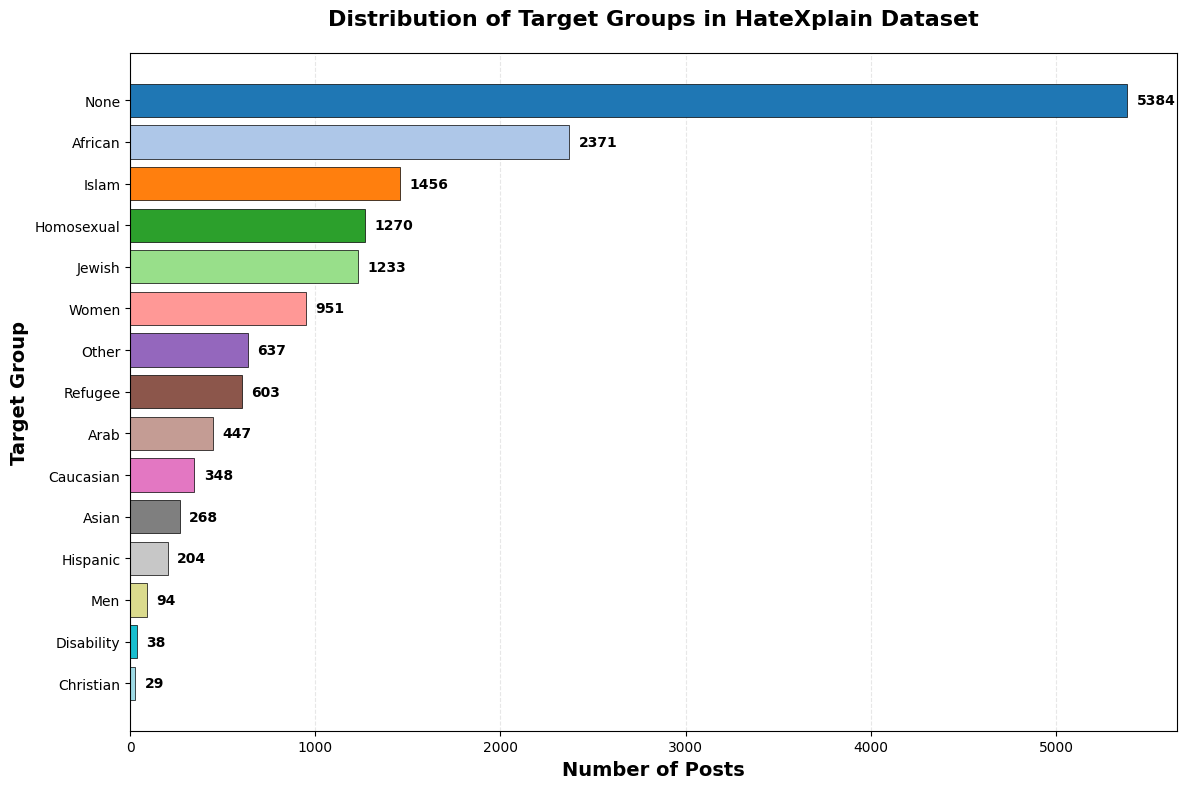

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#Used claude to get plot for diagram
# Data
target_groups = ['None', 'African', 'Islam', 'Homosexual', 'Jewish', 'Women',
                 'Other', 'Refugee', 'Arab', 'Caucasian', 'Asian', 'Hispanic',
                 'Men', 'Disability', 'Christian']
counts = [5384, 2371, 1456, 1270, 1233, 951, 637, 603, 447, 348, 268, 204, 94, 38, 29]

# Create colorful palette
colors = plt.cm.tab20(np.linspace(0, 1, len(target_groups)))

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Create bar chart
bars = ax.barh(target_groups, counts, color=colors, edgecolor='black', linewidth=0.5)

# Customize
ax.set_xlabel('Number of Posts', fontsize=14, fontweight='bold')
ax.set_ylabel('Target Group', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Target Groups in HateXplain Dataset',
             fontsize=16, fontweight='bold', pad=20)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax.text(count + 50, i, str(count),
            va='center', fontsize=10, fontweight='bold')

# Grid for readability
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Invert y-axis so highest count is on top
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('target_group_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Chart for poster

FileNotFoundError: [Errno 2] No such file or directory: 'figs/task1_accuracy_comparison.png'

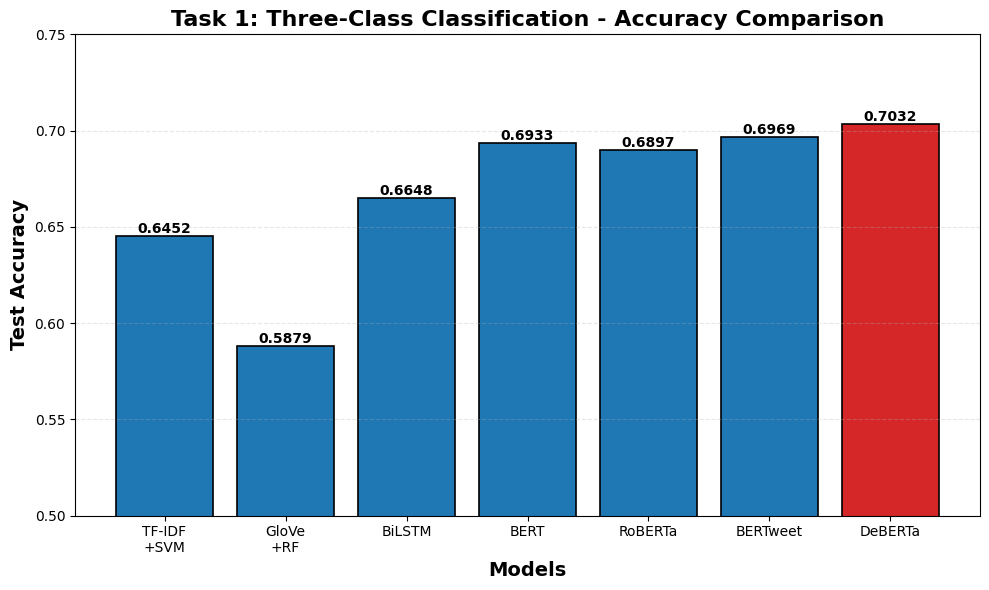

In [2]:
import matplotlib.pyplot as plt
import numpy as np
#used claude to get plot for diagram
# Data
models = ['TF-IDF\n+SVM', 'GloVe\n+RF', 'BiLSTM', 'BERT', 'RoBERTa', 'BERTweet', 'DeBERTa']
accuracy_task1 = [0.6452, 0.5879, 0.6648, 0.6933, 0.6897, 0.6969, 0.7032]  # Replace 0.XX with BiLSTM accuracy

# Colors - highlight DeBERTa
colors = ['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#d62728']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracy_task1, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylabel('Test Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.title('Task 1: Three-Class Classification - Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylim([0.5, 0.75])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('figs/task1_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()